<a href="https://colab.research.google.com/github/piyuss/hyperspectral-image-demo/blob/main/hyperspectral_image_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tutorial: Hyperspectral Image Analysis

In this tutorial, we will go through steps in hyperspectral image processing using plant images as demo images. These are the steps in we will follow:



1.   Download and import hyperspectral data
2.   Inspect the true color composite image
3.   Segment the plant pixels
4.   Extract spectral data and calculate reflectance
5.   Examine dimension reduction and modeling techniques



First, let's download the files we will work with. Hyperspectral image files tend to be large and will take a while to download. Run the code cell below by clicking on the **Play icon** to the left of the cell. You can also run the cell by clicking on the cell and pressing **CTRL/CMD+ENTER**.

# Download data

In [1]:
!wget -O download.zip https://www.dropbox.com/s/l9ms3tgk1tpi1bm/images.zip?dl=1
!unzip download.zip

--2021-05-15 23:57:04--  https://www.dropbox.com/s/l9ms3tgk1tpi1bm/images.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/l9ms3tgk1tpi1bm/images.zip [following]
--2021-05-15 23:57:04--  https://www.dropbox.com/s/dl/l9ms3tgk1tpi1bm/images.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfd624812aff62179d52f4fd59e.dl.dropboxusercontent.com/cd/0/get/BOnyOgFDa0NRlYITEFBZTs6A0x_TkeJuTfuZ7OJMLfMXSb-FQ4MAFNVC-Uzt4AQSzgZC4c6rVJdn4Kht2IliaS0q9qynrsxL9O4fTVZyaLBScbW1-hqVzlb_P6dSmduSWli6djVBPLdG_9y-kPGz4GrN/file?dl=1# [following]
--2021-05-15 23:57:04--  https://ucfd624812aff62179d52f4fd59e.dl.dropboxusercontent.com/cd/0/get/BOnyOgFDa0NRlYITEFBZTs6A0x_TkeJuTfuZ7OJMLfMXSb-FQ4MAFNVC-Uzt4AQSzgZC4c6rVJdn4Kht2IliaS0q9qynrs

Let us look at the files that we downloaded. 

In [2]:
from glob import glob #Function to retrieve filenames from directory
file_list = glob("images/" + "*.*", recursive = True)
print("List of filenames:", file_list)

List of filenames: ['images/P0_A_B.bil.hdr', 'images/N8_A_B.bil.hdr', 'images/P0_A_B.bil', 'images/N8_A_B.bil']


We have two different types of files in the directory:

1. BIL files are binary files containing uncompressed image pixel data. BIL files simply store pixel values row-wise for each channel. We need additional information on the number of rows, columns, and bands to read the BIL files.

2. HDR files, or header files, contain the information about the BIL files.

<p align="center"> <img src= "https://github.com/piyuss/hyperspectral-image-demo/blob/main/illustrations/bil_format.PNG?raw=true">

<p align="center"> <i> Structure of a Band Interleaved by Line (BIL) file


**Image source:** https://desktop.arcgis.com/en/arcmap/10.3/manage-data/raster-and-images/bil-bip-and-bsq-raster-files.htm +

+ *This link will also be useful to read about other image formats you may come across depending on the type of data and the sensor you are using*

We can look at the size of these files to understand that one is a huge binary file and the other is a text file with metadata.

In [3]:
import os
print("The size of ", file_list[0], " is ", os.path.getsize (file_list[0]), "bytes.")
print("The size of ", file_list[1], " is ", os.path.getsize (file_list[1]), "bytes.")

The size of  images/P0_A_B.bil.hdr  is  4053 bytes.
The size of  images/N8_A_B.bil.hdr  is  4053 bytes.



# Import data

Let us look at one of the header files to understand the file format before we read in the data.

In [4]:
import pandas as pd
metadata_list = glob("images/" + "*.bil.hdr")
header_info = pd.read_table(metadata_list[0], header=None)
header_info.columns = ["metadata"]
print(header_info)

                                             metadata
0                                                ENVI
1                                    interleave = bil
2                                      data type = 12
3                                        lines = 2000
4                                      samples = 1600
5                                         bands = 462
6                                      bit depth = 12
7                                      ceiling = 4095
8                                  sample binning = 1
9                                spectral binning = 2
10                                   line binning = 1
11                                    shutter = 19.56
12                                         gain = 0.0
13                     framerate = 50.090162292125825
14                   imager serial number = 100124-73
15                                     byte order = 0
16                                  header offset = 0
17  wavelength = {389.63, 39

The header file contains everything one would like to know about the image. The size of the image can be deduced from lines, samples, and bands. The bit depth and byte order can be important depending on how we decide to read in the data. 

From the first line of the header file, we learn that the format of the header is ENVI. Detailed information about this format can be found here: https://www.l3harrisgeospatial.com/docs/enviheaderfiles.html

**INCLUDE AN IMAGE SHOWING WHAT THE LINES, SAMPLES, AND BANDS MEAN.**

We can use this information and write a program to read BIL files, but a smarter way is to use existing libraries. For this demonstration, we are going to use the open source Spectral Python (SPy) Library which is designed for hyperspectral image analysis. The documentation for the library is here: http://www.spectralpython.net/

The source code is here: https://github.com/spectralpython 

While the specific functions will be different depending on the library used, the general principles remain the same. SPy has a lot of nice abstractions. The user can read most common hyperspectral image formats with just the filename. Functions are provided for many common image operations so that almost everything can be achieved with a basic knowledge of Python and its libraries for scientific computing such as Numpy. Resources for learning Python are everywhere; one free resource that I recommend is here: https://greenteapress.com/wp/think-python/

We will first install SPy using the Python Package Index (PyPi) and import it.

In [5]:
!pip install spectral
from spectral import *

     |████████████████████████████████| 184kB 3.8MB/s 
  Created wheel for spectral: filename=spectral-0.22.2-cp37-none-any.whl size=212938 sha256=7c8809894e1c59370475dc0b1471e10fd2c2fba18c8643a02c2799b6f75540cc
  Stored in directory: /root/.cache/pip/wheels/fb/00/da/ac778d1ab6e196cb7f56d104d4dfdfc0aad4e2b208275c0726
Successfully built spectral


To read a file with an ENVI header, SPy provides a special function:

In [6]:
img = envi.open(metadata_list[0])

You will notice that envi.open() function was unexpectedly fast. This is because the hyperspectral data is not read into the computer's memory; only the metadata in the header file has been read in. However, we can use the object img to extract information abou the image as well as to extract specific channels or pixels.

It supports common Numpy methods and operators.

We can check the dimensions of the image:

In [7]:
img.shape

(2000, 1600, 462)

We can inspect the image intensity at the 200th row and 1000th column of the 100th channel:

In [8]:
img[200,1000,100]

433

Now that we are able to access the numbers in the hyperspectral image cube, we can begin to do more interesting things. Before we start doing that, it is a good idea to read the entire image into memory so that operations can be faster. Until now, the program read values into memory only when specifically requested with the subscript ([ ]) notation. You can check the RAM usage of your Colab session from the menu on the top right now and after we run the next code cell to see that the image is read into memory only when the load() method is used. It is a good idea to be mindful of the size of your data, the computer's memory, and how it is being used when dealing with such large files

In [9]:
arr = img.load()

One more thing we will do is to subsample the data cube. This will create a lighter datacube that will be processed faster. This is not necessary (or desirable) in an actual analysis but will help us move faster in the Colaboratory environment.

In [10]:
arr = arr[::3,::3,:]

In [11]:
arr.shape

(667, 534, 462)

# Inspect color image

We will now look at the image channels that are useful for segmentation and analysis. The dataset that we are working with contains the visible and near infra-red wavelengths, so it is possible to extract the red, green, and blue channels to look at the color image. 

<p align="center"> <img src= "https://github.com/piyuss/hyperspectral-image-demo/blob/main/illustrations/spectrum_wiki.png?raw=true" width = 40% >

As we see in the image above, the red, green, and blue wavelengths can be taken around 650 nm, 550 nm, and 450 nm respectively. For more information on the visible spectrum: https://www.britannica.com/science/color/The-visible-spectrum

We saw that we can use the subscript operator [ ] to extract particular channels from the image. But where do the wavelengths for the red, green, and blue channels lie? In this case, the answer is in the metadata file.


In [12]:
print(header_info["metadata"][17])

wavelength = {389.63, 390.95, 392.27, 393.58, 394.9, 396.22, 397.54, 398.86, 400.17, 401.49, 402.81, 404.13, 405.45, 406.77, 408.08, 409.4, 410.72, 412.04, 413.36, 414.68, 416.0, 417.32, 418.64, 419.96, 421.28, 422.6, 423.92, 425.24, 426.56, 427.88, 429.2, 430.52, 431.84, 433.16, 434.48, 435.8, 437.12, 438.44, 439.76, 441.08, 442.4, 443.72, 445.04, 446.37, 447.69, 449.01, 450.33, 451.65, 452.97, 454.3, 455.62, 456.94, 458.26, 459.58, 460.91, 462.23, 463.55, 464.87, 466.2, 467.52, 468.84, 470.17, 471.49, 472.81, 474.14, 475.46, 476.78, 478.11, 479.43, 480.75, 482.08, 483.4, 484.73, 486.05, 487.37, 488.7, 490.02, 491.35, 492.67, 494.0, 495.32, 496.65, 497.97, 499.3, 500.62, 501.95, 503.27, 504.6, 505.92, 507.25, 508.58, 509.9, 511.23, 512.55, 513.88, 515.21, 516.53, 517.86, 519.19, 520.51, 521.84, 523.17, 524.49, 525.82, 527.15, 528.47, 529.8, 531.13, 532.46, 533.78, 535.11, 536.44, 537.77, 539.09, 540.42, 541.75, 543.08, 544.41, 545.74, 547.06, 548.39, 549.72, 551.05, 552.38, 553.71, 55

If we count or write a function to find the location of the RGB wavelengths, we will find that 450.33 nm is the 47th channel, 549.72 nm is the 122th channel, and 649.64 nm is the 197th channel.

We will write a small function to extract these channels and create an RGB image,and another function to display an image in the IPython notebook.



In [13]:
def show_image(img1):
    fig1, ax1 = plt.subplots(figsize=(5, 5))
    ax1.imshow(img1, cmap = 'gray')

In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def increase_brightness(img, value=80):
    img = img.astype(np.uint8)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

def create_rgb(hyper_cube):
    rgb_image = hyper_cube[:,:,[197,122,47]]
    rgb_image = cv2.normalize(rgb_image, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    rgb_image = rgb_image.astype(np.uint8)
    rgb_image = increase_brightness(rgb_image)
    return rgb_image


In [15]:
rgb_img = create_rgb(arr) 
rgb_img.shape

(667, 534, 3)

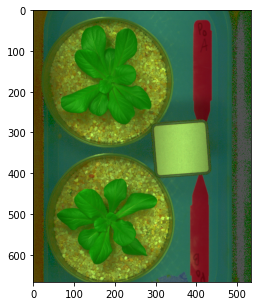

In [16]:
show_image(rgb_img)

We can similarly extract the NDVI image.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


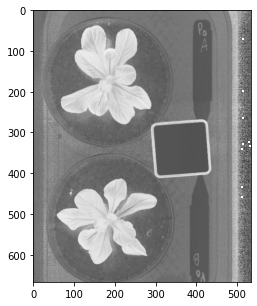

In [17]:
def create_ndvi(hyper_cube):
    band_750 = hyper_cube[:,:,272]
    band_750 = band_750.astype(np.double)
    band_705 = hyper_cube[:,:,197]
    band_705 = band_705.astype(np.double)

    ndvi_image = np.true_divide((band_750-band_705),(band_750+band_705));
    ndvi_image = ndvi_image[:,:,0]
    
    return ndvi_image

ndvi_img = create_ndvi(arr)
show_image(ndvi_img)

# Segment vegetation pixels

The NDVI image distinctly separates the plant pixels, but we still need to threshold it to get a binary mask. We first look at the histogram of the NDVI image to determine a suitable threshold if it exists.

Text(0.5, 1.0, 'Histogram of NDVI values')

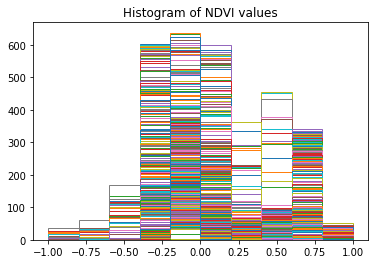

In [18]:
plt.hist(ndvi_img, histtype="step")
plt.title("Histogram of NDVI values")

Looking at the histogram, can make an informed guess that taking a threshold around 0.25 will separate the vegetation pixels from the non-vegetation pixels.

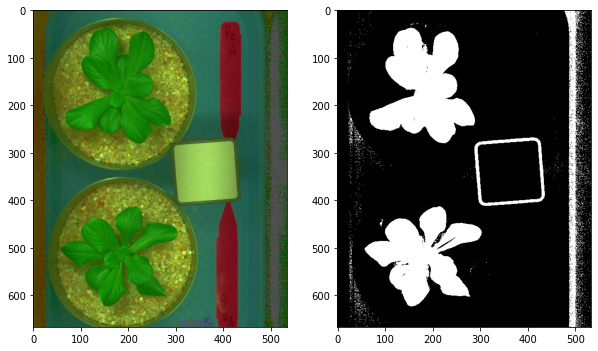

In [19]:
def visualize_ndvi_thresh(threshold_value):
    f, axarr = plt.subplots(1,2, figsize =(10,10))
    axarr[0].imshow(rgb_img)
    axarr[1].imshow(ndvi_img>threshold_value,cmap="gray")

visualize_ndvi_thresh(0.25)

While the segmentation is already acceptable, we can see some error near the upper plant. We will experiment with a higher value of NDVI to see if that will give better results.

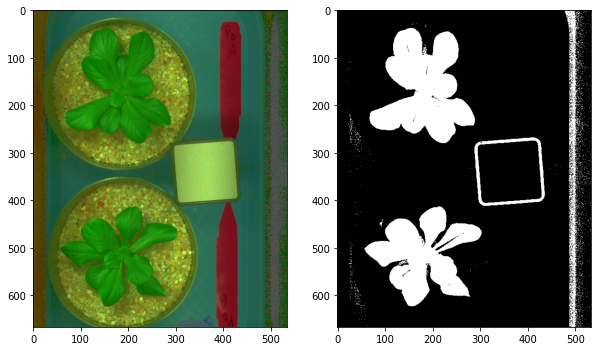

In [20]:
visualize_ndvi_thresh(0.35)

The estimation of threshold is not necessarily a process of trial and error. We can try using the popular Otsu's algorithm, for example.

In [21]:
from skimage import filters
otsu_threshold = filters.threshold_otsu(ndvi_img[~np.isnan(ndvi_img)])
print("The threshold from Otsu's algorithm is", otsu_threshold)

The threshold from Otsu's algorithm is 0.25390625


The Otsu threshold is close to our estimated threshold. In practice, we would test on a few random images to see that the threshold is applicable to the entire set before running the program for the batch. For now, let's work with a threshold of 0.35. 

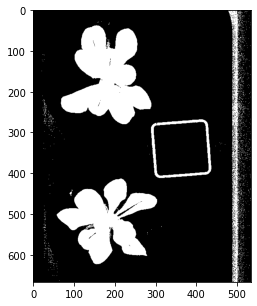

In [22]:
mask_initial = ndvi_img>0.35
show_image(mask_initial)

We still have non-plant pixels that are segmented out, particularly towards the right edge of the image. The removal of these unwanted noise pixels can be done in a number of ways. The segmentation and noise-removal are steps where tools and techniques in traditional computer vision become useful.

One way to remove the noise (and keep the two lettuce blobs) is to simply extract the two largest connected components in the binary image. Below, we create a function that returns a 3-D data structure with the n largest blobs, one in each channel.

In [23]:
def get_largest_blobs(binary_image, num_blobs):

  #find connected components 
  binary_image = binary_image.astype(np.uint8)
  num_comps, output, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)
  
  sizes = stats[1:, -1]; nb_components = num_comps - 1
   
  blob_indices = np.argsort(sizes)[::-1][0:num_blobs]
  
  aggregate_img = np.zeros((binary_image.shape[0], binary_image.shape[1],num_blobs))

  centroid_list = centroids[blob_indices+1]
  for i in range(num_blobs):
        img2 = np.zeros((output.shape))
        img2[output == blob_indices[i]+1] = 255
        aggregate_img[:,:,i] = img2

  return aggregate_img, centroid_list

Text(0.5, 1.0, 'Individual mask 2')

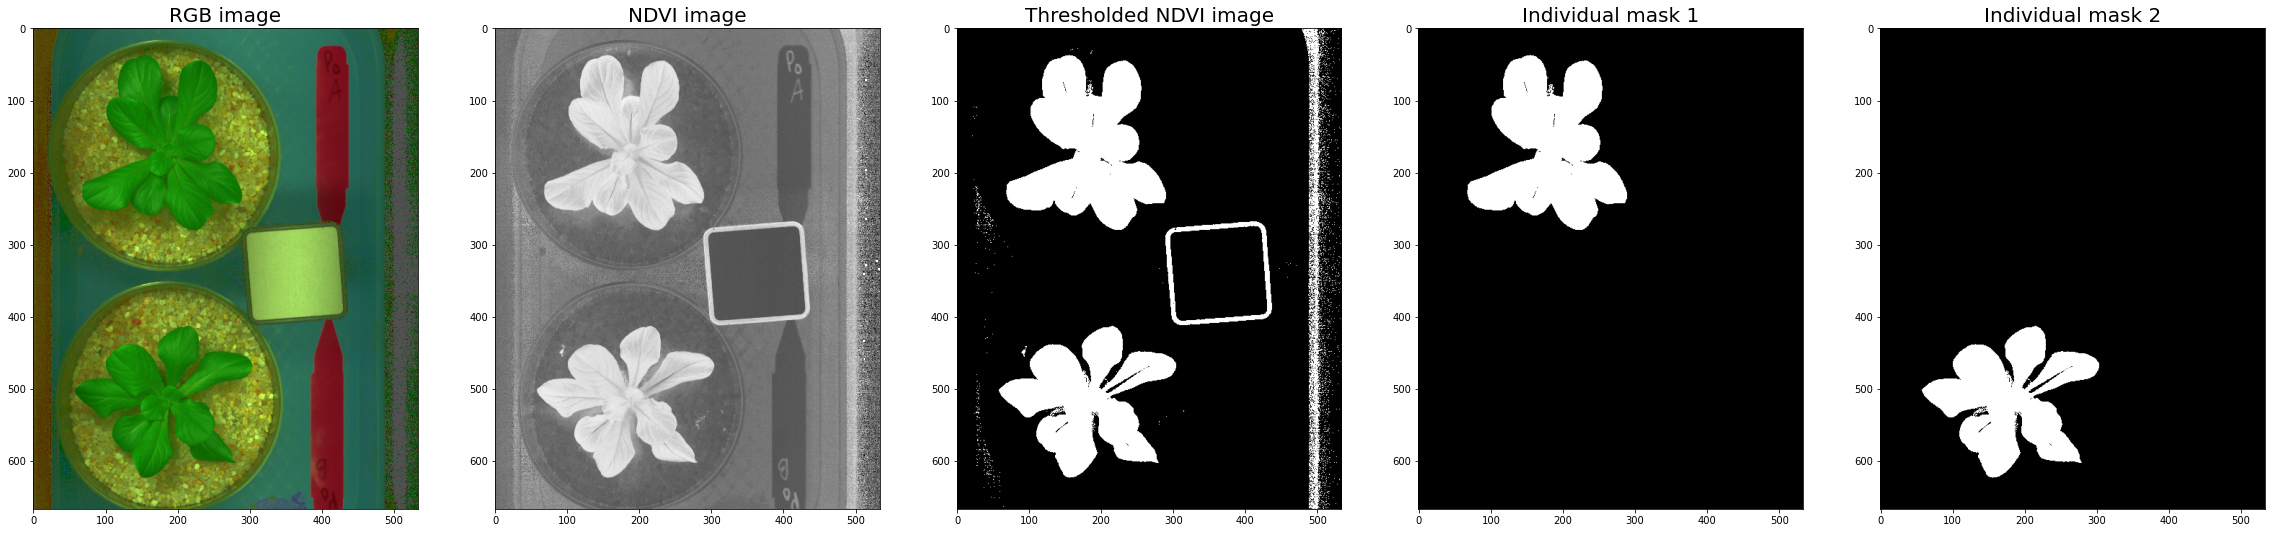

In [24]:
f, axarr = plt.subplots(1,5, figsize =(40,40))
axarr[0].imshow(rgb_img, cmap=plt.get_cmap("gray"))
axarr[0].set_title('RGB image', fontsize=20)
axarr[1].imshow(ndvi_img, cmap=plt.get_cmap("gray"))
axarr[1].set_title('NDVI image', fontsize=20)
axarr[2].imshow(mask_initial, cmap=plt.get_cmap("gray"))
axarr[2].set_title('Thresholded NDVI image', fontsize=20)

aggregate_img, centroids = get_largest_blobs(binary_image = mask_initial,
                                             num_blobs = 2)

axarr[3].imshow(aggregate_img[:,:,0], cmap=plt.get_cmap("gray"))
axarr[3].set_title('Individual mask 1', fontsize=20)
axarr[4].imshow(aggregate_img[:,:,1], cmap=plt.get_cmap("gray"))
axarr[4].set_title('Individual mask 2', fontsize=20)

At this point we have successfully segmented the vegetation pixels and also separated the individual plant images present in the image. These operations can be more involved depending on the level of control in the environment for data acquisition. It would also require more work if the plants were touching each other in the image. We can see here that a well designed data acquisition process can make subsequent steps much easier.

Since we have created the masks, we will be able to extract the intensities for each wavelength channel. 

In [25]:
plant1_mask = aggregate_img[:,:,0]
b = np.repeat(plant1_mask[:, :, np.newaxis], 462, axis=2)

import numpy.ma as ma
mask_arr = ma.masked_array(arr, mask = np.uint8(1*(b==0))) 

spectrum_list = [None] * mask_arr.shape[2]
i = 0
for i in range(mask_arr.shape[2]):
  channel_mask = mask_arr[:,:,i]
  spectrum_list[i] = channel_mask.mean()

The cell above calculates the mean intensity of the plant pixels for each channel in a loop. We can visualize the masked intensity image from the last channel of the datacube.

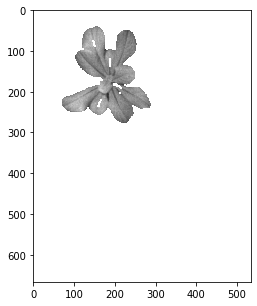

In [26]:
show_image(channel_mask.squeeze(axis=2))

Next, we will plot the average intensity values for the plant region against the wavelength.

In [27]:
def plot_spectrum(spectrum_data, title):
    fig1, ax1 = plt.subplots(figsize=(6, 6))
    wavelength_list = [float(i) for i in header_info["metadata"][17].split("{")[1].split("}")[0].split(",")]
    ax1.plot(wavelength_list, spectrum_data)
    ax1.set_xlabel("Wavelength (nm)")
    plt.title(title)

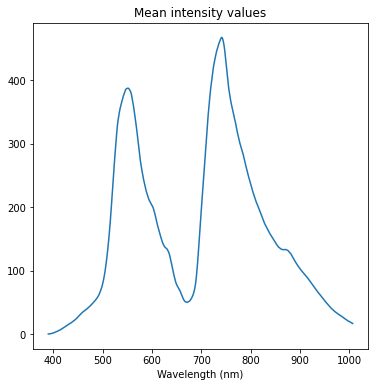

In [28]:
plot_spectrum(spectrum_list, "Mean intensity values")

We can see that the resulting curve is not at all representative of the reflectance pattern that we expect from plants. We would expect higher reflectance in the green region, a lower reflectance in the red area and a much higher reflectance in the near-infrared region. We do not see that in the above chart because it is showing us the raw intensity values captured by the sensor. These raw numbers are naturally dependent upon the ambient light. In order to get meaningful values, we need to characterize our incoming light and try to measure the reflected radiation in proportion to the incident radiation at each wavelength.

The purpose of the calibration panel is precisely to facilitate this correction of intensities. The panel has reflectance values that are known, often from factory calibration. The concept here is that if we can obtain the intensities captured from a surface of known reflectance, we can derive an idea of the incident light. For example, if a surface has a known 20% reflectance value at 550 nm, and it has an average pixel intensity of 100, we use a linear relationship and assume that a surface with 100% reflectance will have an average pixel intensity of 100/0.2 = 500.

To find the average pixel intensity of our calibration panel, we need to find a way to segment it out similar to the process we used for plant pixel segmentation. Often, an empirical approach is useful to find features that enable accurate segmentation of objects. In this case, we found that the calibration panel had a unique combination of intensity values at 550 nm and around 800 nm.



In [29]:
g = arr[:,:,122]
band800 = arr[:,:,310]
ratio1 = (g/band800).squeeze(axis=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


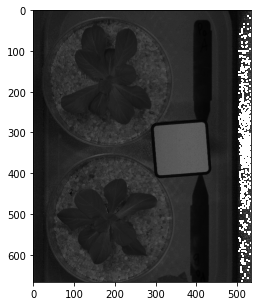

In [30]:
show_image(ratio1)

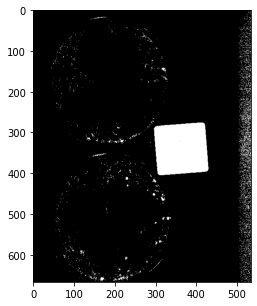

In [31]:
thresholded_standard = np.asarray(ratio1>4)

show_image(thresholded_standard)

In [32]:
thresholded_standard, centroid1 = get_largest_blobs(thresholded_standard,1)
standard_mask = thresholded_standard.squeeze(axis=2)

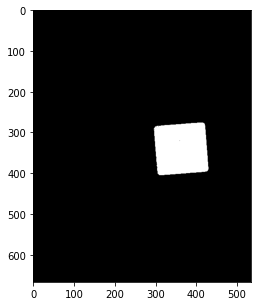

In [33]:
show_image(standard_mask)

In [34]:
standard_mask_cube = np.repeat(standard_mask[:, :, np.newaxis], 462, axis=2)

import numpy.ma as ma
mask_arr = ma.masked_array(arr, mask = np.uint8(1*(standard_mask_cube==0))) 

standard_spectrum = [None] * mask_arr.shape[2]
i = 0
for i in range(mask_arr.shape[2]):
  channel_mask = mask_arr[:,:,i]
  standard_spectrum[i] = channel_mask.mean()

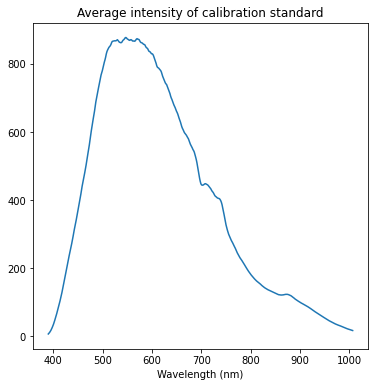

In [35]:
plot_spectrum(standard_spectrum, "Average intensity of calibration standard")

We know that the calibration standard has reflectance values around 20% throughout the wavelength range. However, the reflectance values are not constant throughout even for the calibration panel and the best way to conduct radiometric correction is to use the factory calibration data. This is simply the reflectance of the panel at various wavelengths measured during its calibration. 

In [36]:
!wget https://raw.githubusercontent.com/piyuss/hyperspectral-image-demo/main/files/calibration.csv

--2021-05-15 23:59:55--  https://raw.githubusercontent.com/piyuss/hyperspectral-image-demo/main/files/calibration.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5928 (5.8K) [text/plain]
Saving to: ‘calibration.csv’

calibration.csv     100%[===================>]   5.79K  --.-KB/s    in 0s      

2021-05-15 23:59:56 (51.7 MB/s) - ‘calibration.csv’ saved [5928/5928]



In [37]:
calibration_file = pd.read_csv("calibration.csv")

In [38]:
calibration_file

,wavelength,reflectance
0,389.63,0.213
1,390.95,0.213
2,392.27,0.213
3,393.58,0.213
4,394.90,0.213
...,...,...
457,1001.45,0.269
458,1002.81,0.269
459,1004.17,0.269
460,1005.53,0.269


In [40]:
calib_spectrum = calibration_file["reflectance"]

In [41]:
plant_reflectance = np.asarray(spectrum_list)/np.asarray(standard_spectrum)*np.asarray(calib_spectrum)

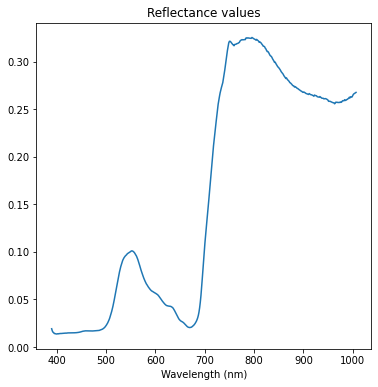

In [42]:
plot_spectrum(plant_reflectance, "Reflectance values")